# CodeTheGenome
# Topic: Genetic Variant Classifications

## Context
ClinVar is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

## Content
The objective is to predict whether a ClinVar variant will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

* Likely Benign or Benign
* VUS
* Likely Pathogenic or Pathogenic
Conflicting classification has been assigned to the CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

In [22]:
pip install catboost

In [23]:
pip install category_encoders

In [24]:
# ──────────────────────────────────────────────────────────
# Standard Libraries
# ──────────────────────────────────────────────────────────
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ──────────────────────────────────────────────────────────
# Visualization Helpers
# ──────────────────────────────────────────────────────────
import missingno as msno                      # missing-value visualizations
import shap                                   # SHAP feature importance plots

# ──────────────────────────────────────────────────────────
# Scikit-Learn Core Utilities
# ──────────────────────────────────────────────────────────
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, RocCurveDisplay
)

# ──────────────────────────────────────────────────────────
# Machine Learning Models
# ──────────────────────────────────────────────────────────
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# ──────────────────────────────────────────────────────────
# Optional Encoders
# ──────────────────────────────────────────────────────────
from category_encoders import BinaryEncoder   # used for optional encoding

# ──────────────────────────────────────────────────────────
# Global Settings
# ──────────────────────────────────────────────────────────
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
# plt.style.use("seaborn-whitegrid")             # clean plot style


## Step 1: Dataset

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#Read The Dataset
url = "/content/drive/MyDrive/clinvar_conflicting_dataset.csv"

data = pd.read_csv(url)
data.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

## Step 2 – Feature-Specific Data Cleaning & Augmentation
we now reshape several biologically-important columns so the model can learn from them rather than shrug them off as messy strings or NaNs.





| Group                                      | Raw format → cleaned features                                  | Why it helps predict “conflict”                                                                 |
|-------------------------------------------|----------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Transcript positions (Protein_position, CDS_position, cDNA_position) | "123-456" → start coordinate, length (end–start)               | Start ≈ location along transcript, length ≈ indel size → both correlate with conflicting calls. |
| Exon/Intron depth (EXON, INTRON)          | "3/5" → 0.60 ratio + _ratio_NA                                 | Tells how far into the transcript the variant sits; missingness itself is informative.           |
| Population rarity (AF_ESP, AF_TGP)        | NaN → 0.0 (“never seen”) + _AF_NA                              | Conflicting calls cluster in ultra-rare alleles; we keep rarity while flagging absent data.     |
| Misc. fixes                               | • Cast STRAND to compact Int8<br>• Drop columns with ≥ 99% NaNs<br>• Remove orphan _NA flags | Saves memory and avoids 100%-ones dummies that add no signal.                                   |


In [28]:


def summarize_missing_and_unique_values(df: pd.DataFrame) -> pd.DataFrame:
    """Return a table of missing counts/%, dtype and cardinality per column."""
    summary = (
        df
        .agg(['count', 'size'])
        .T
        .rename(columns={'count': 'Non_Missing_Count', 'size': 'Total'})
    )
    summary['Missing_Count']      = summary['Total'] - summary['Non_Missing_Count']
    summary['Missing_Percentage'] = (summary['Missing_Count'] / summary['Total']).round(4)
    summary['Data_Type']          = df.dtypes
    summary['Unique_Value_Count'] = df.nunique(dropna=False)
    # small sample of uniques (up to 5)
    summary['Unique_Values_Sample'] = (
        df.apply(lambda s: list(s.drop_duplicates().iloc[:5]))
    )
    return summary.drop(columns='Total').sort_values('Missing_Count', ascending=False)

In [29]:
summary_df = summarize_missing_and_unique_values(data)
summary_df

,Non_Missing_Count,Missing_Count,Missing_Percentage,Data_Type,Unique_Value_Count,Unique_Values_Sample
MOTIF_POS,2,65186,1.0000,float64,2,"[nan, 1.0]"
MOTIF_NAME,2,65186,1.0000,object,3,"[nan, Egr1:MA0341.1, FOXA1:MA0546.1]"
MOTIF_SCORE_CHANGE,2,65186,1.0000,float64,3,"[nan, -0.063, -0.097]"
HIGH_INF_POS,2,65186,1.0000,object,2,"[nan, N]"
DISTANCE,108,65080,0.9983,float64,97,"[nan, 1811.0, 1855.0, 2202.0, 1651.0]"
SSR,130,65058,0.9980,float64,3,"[nan, 1.0, 16.0]"
CLNSIGINCL,167,65021,0.9974,object,138,"[nan, 424754:Likely_pathogenic, 30118:risk_fac..."
CLNDISDBINCL,167,65021,0.9974,object,94,"[nan, MedGen:C1828210,OMIM:153870,Orphanet:ORP..."
CLNDNINCL,167,65021,0.9974,object,102,"[nan, Bull's_eye_maculopathy|Methylmalonic_aci..."
INTRON,8803,56385,0.8650,object,1930,"[nan, 6/27, 8/17, 3/20, 24/24]"


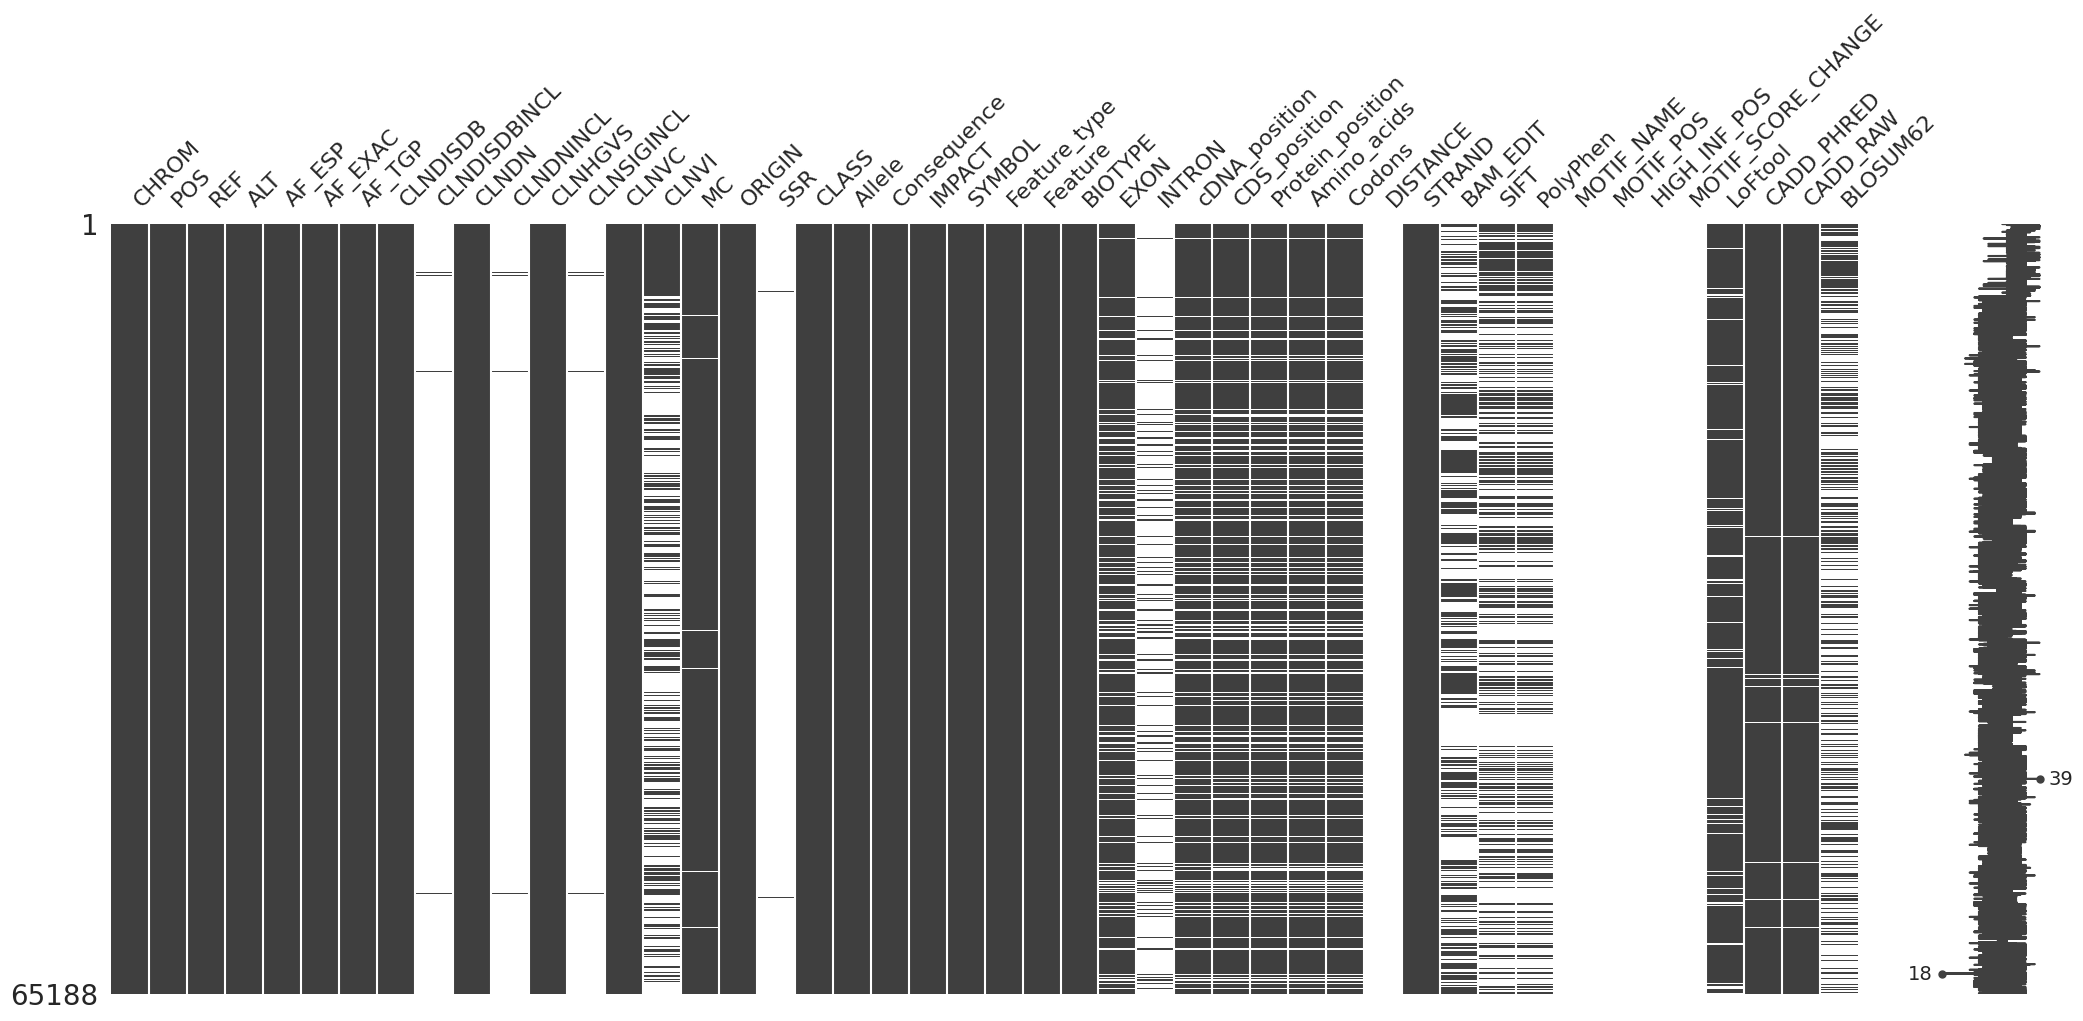

In [30]:
# Visualize missing data
msno.matrix(data)
plt.show()

In [31]:
# ------------------------------------------------------------------
# 2.  Field-specific cleaners
# ------------------------------------------------------------------
from typing import Tuple

def _split_position_field(col: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """
    Split "123-456" → start, end (both numeric, NA-safe).
    Returns (start, length)  where start = first valid coord,
                              length = abs(end - start) or NA
    """
    # Ensure the series is string
    parts = col.astype(str).str.split('-', n=1, expand=True)
    start = pd.to_numeric(parts[0].replace('?', np.nan), errors='coerce')
    end   = pd.to_numeric(parts[1].replace('?', np.nan), errors='coerce')

    # If start is NA but end is not, use end as start (your original logic)
    start = start.fillna(end)
    length = (end - start).abs()
    return start, length

def _parse_fraction(col: pd.Series) -> pd.Series:
    """
    Convert strings like '3/5' or '10/11' into a float ratio.
    Invalid or missing patterns return NaN.
    """
    mask = col.astype(str).str.match(r'^\d+/\d+$')
    num  = col[mask].str.split('/', expand=True).iloc[:, 0].astype(float)
    den  = col[mask].str.split('/', expand=True).iloc[:, 1].astype(float)
    ratio = pd.Series(index=col.index, dtype='float64')
    ratio[mask] = num / den.replace(0, np.nan)
    return ratio

# ------------------------------------------------------------------
# 3.  Main cleaner
# ------------------------------------------------------------------
def clean_clinvar_dataset(df: pd.DataFrame,
                          missing_tol: float = 0.99,
                          log_dir: str | None = None
                         ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
        cleaned_df, summary_df
    """
    df = df.copy()

    # -- STEP 0: ensure unique key ---------------------------------
    if 'KEY' not in df.columns:
        df.insert(0, 'KEY', df['CLNHGVS'])
    assert df['KEY'].is_unique, "`KEY` is not unique"

    # -- STEP 1: drop almost-empty columns -------------------------
    summary0 = summarize_missing_and_unique_values(df)
    drop_cols = summary0.loc[summary0['Missing_Percentage'] >= missing_tol, :].index.tolist()
    df.drop(columns=drop_cols, inplace=True)

    # -- STEP 2: clean genomic / protein position fields -----------
    # 2-A  Genomic / protein positions  ───────────────────────────────────────
    for col in ['Protein_position', 'CDS_position', 'cDNA_position']:
        if col not in df.columns:               # skip if column absent
            continue
        start, length              = _split_position_field(df[col])
        df[f"{col}_start"]         = start
        df[f"{col}_length"]        = length
        df[f"{col}_start_NA"]      = start.isna().astype('int8')
        df[f"{col}_length_NA"]     = length.isna().astype('int8')
        df.drop(columns=col, inplace=True)

    # -- STEP 3: parse EXON / INTRON fraction fields ---------------
    for col in ['EXON', 'INTRON']:
        if col not in df.columns:
            continue
        ratio = _parse_fraction(df[col])
        df[f'{col}_ratio']  = ratio
        df[f'{col}_ratio_NA'] = ratio.isna().astype('int8')
        df.drop(columns=col, inplace=True)

        # optional logging of invalid patterns
        if log_dir is not None:
            invalid_rows = df.loc[ratio.isna() & df[col].notna(), ['KEY']]
            invalid_rows.to_csv(f"{log_dir}/invalid_{col}.csv", index=False)

    # -- STEP 4: allele-frequency columns --------------------------
    af_cols = ['AF_ESP', 'AF_TGP']
    for col in af_cols:
        if col not in df.columns:
            continue
        df[f'{col}_NA'] = df[col].isna().astype('int8')
        df[col].fillna(0.0, inplace=True)          # 0 = "not seen"

    # -- STRAND casting --------------------------------
    if 'STRAND' in df.columns:
        df['STRAND'] = pd.to_numeric(df['STRAND'], errors='coerce').astype('Int8')

    # -- STEP 6: orphan NA-flags check -----------------------------
    orphan_flags = [f for f in df.columns if f.endswith('_NA') and f[:-3] not in df.columns]
    df.drop(columns=orphan_flags, inplace=True)

    # -- STEP 7: final summary ------------------------------------
    summary = summarize_missing_and_unique_values(df)
    return df.reset_index(drop=True), summary




ClinVar raw columns mix free-text ranges (123-456), fractions (3/5), and patchy allele-freq tables. Converting each to pure numeric features plus explicit missing flags unlocks signal (e.g., rarity, variant length, exon depth) that gradient-boosting models can exploit, while still letting the model know when information was absent.

In [32]:
cleaned_df, cleaned_summary = clean_clinvar_dataset(data)

print("Final shape:", cleaned_df.shape)
display(cleaned_summary)


Final shape: (65188, 51)


,Non_Missing_Count,Missing_Count,Missing_Percentage,Data_Type,Unique_Value_Count,Unique_Values_Sample
Protein_position_length,1172,64016,0.9820,float64,28,"[nan, 2.0, 1.0, 7.0, 8.0]"
CDS_position_length,2167,63021,0.9668,float64,46,"[nan, 1.0, 5.0, 2.0, 19.0]"
cDNA_position_length,2247,62941,0.9655,float64,48,"[nan, 1.0, 5.0, 2.0, 19.0]"
INTRON_ratio,8803,56385,0.8650,float64,1269,"[nan, 0.2222222222222222, 0.47058823529411764,..."
PolyPhen,24796,40392,0.6196,object,5,"[benign, probably_damaging, nan, possibly_dama..."
SIFT,24836,40352,0.6190,object,5,"[tolerated, deleterious_low_confidence, delete..."
BLOSUM62,25593,39595,0.6074,float64,7,"[2.0, -3.0, -1.0, nan, -2.0]"
CLNVI,27659,37529,0.5757,object,27655,"[UniProtKB_(protein):Q96L58#VAR_059317, OMIM_A..."
BAM_EDIT,31969,33219,0.5096,object,3,"[nan, OK, FAILED]"
Amino_acids,55184,10004,0.1535,object,1263,"[E/D, P/L, I/T, G/S, G/C]"


This step adds missingness indicator flags for five mid-missing categorical or score columns—PolyPhen, SIFT, BLOSUM62, CLNVI, and BAM_EDIT—by creating new binary features (e.g., `PolyPhen_NA`) that mark whether a value is missing. These flags are stored as compact `int8` types to save memory. Including missingness as a feature is important because the absence of a value can carry predictive signal, for instance, labs may skip PolyPhen or SIFT annotations for variants they consider benign, making “NA” a subtle benign cue. On the other hand, missing BAM_EDIT values could suggest sequencing difficulties linked to conflicting interpretations. By explicitly flagging NAs, tree-based models like CatBoost or LightGBM can make better use of this information without relying on imputation alone.

In [33]:
mid_missing_cats = ['PolyPhen', 'SIFT', 'BLOSUM62', 'CLNVI', 'BAM_EDIT']
for col in mid_missing_cats:
    cleaned_df[f"{col}_NA"] = cleaned_df[col].isna().astype('int8')


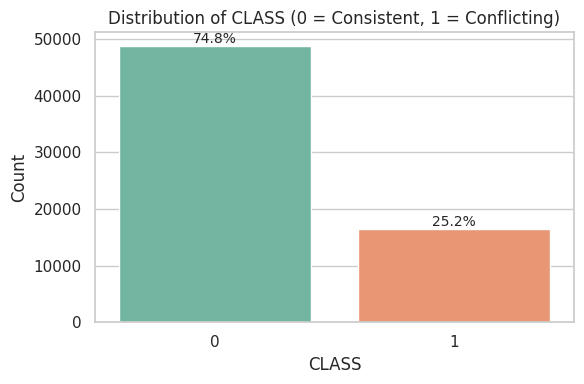

In [34]:
# Set plot style
sns.set(style="whitegrid")

# 1. CLASS distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='CLASS', data=cleaned_df, palette='Set2')

# Add percentage labels
total = len(cleaned_df)
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.title("Distribution of CLASS (0 = Consistent, 1 = Conflicting)")
plt.xlabel("CLASS")
plt.ylabel("Count")
plt.tight_layout()
plt.show()





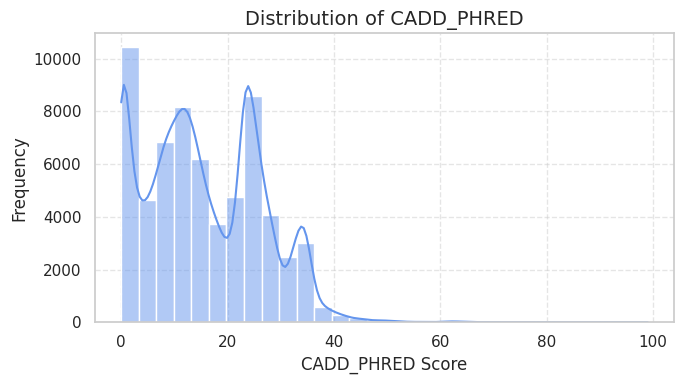

In [35]:
# 2. Univariate histogram: CADD_PHRED
plt.figure(figsize=(7, 4))
sns.histplot(cleaned_df['CADD_PHRED'].dropna(), kde=True, bins=30, color='cornflowerblue')

plt.title("Distribution of CADD_PHRED", fontsize=14)
plt.xlabel("CADD_PHRED Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



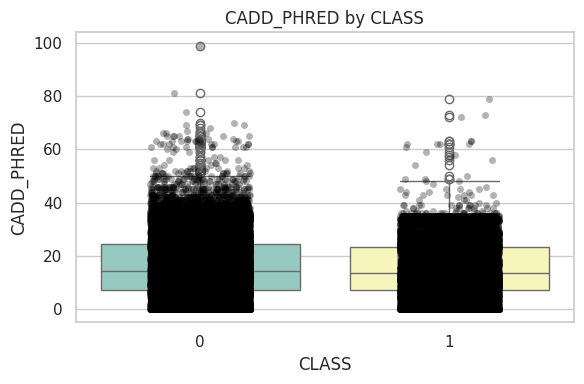

In [36]:
# ------------------------------------------
# 3. Boxplot of CADD_PHRED by CLASS (+strip)
# ------------------------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(x='CLASS', y='CADD_PHRED', data=cleaned_df, palette='Set3')
sns.stripplot(x='CLASS', y='CADD_PHRED', data=cleaned_df,
              color='black', alpha=0.3, jitter=0.2)

plt.title("CADD_PHRED by CLASS")
plt.xlabel("CLASS")
plt.ylabel("CADD_PHRED")
plt.tight_layout()
plt.show()



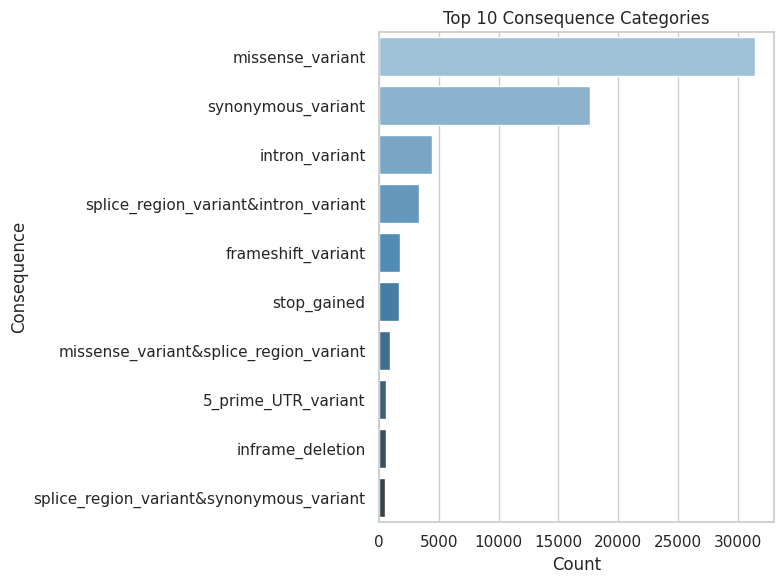

In [37]:
# --------------------------------------------------
# 4. Countplot of Top 10 'Consequence' Categories
# --------------------------------------------------
plt.figure(figsize=(8, 6))
top_consequences = cleaned_df['Consequence'].value_counts().head(10).index
sns.countplot(y='Consequence',
              data=cleaned_df[cleaned_df['Consequence'].isin(top_consequences)],
              order=top_consequences, palette='Blues_d')

plt.title("Top 10 Consequence Categories")
plt.xlabel("Count")
plt.ylabel("Consequence")
plt.tight_layout()
plt.show()



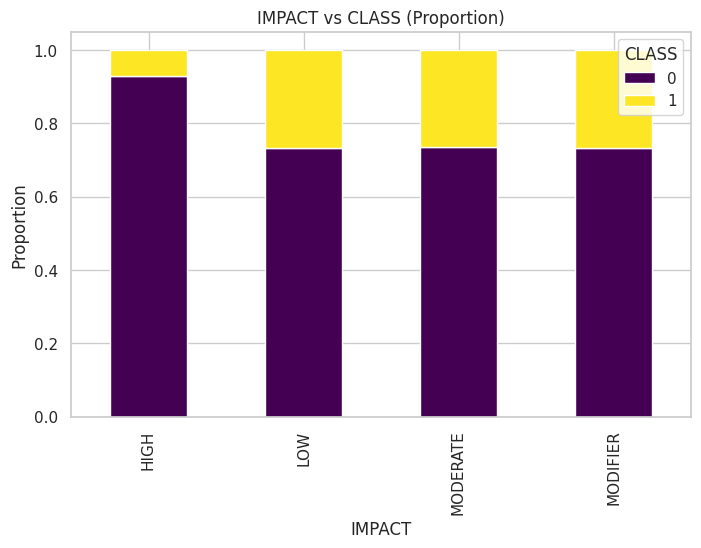

In [38]:
# --------------------------------------
# 5. Stacked Bar: IMPACT vs CLASS
# --------------------------------------
impact_crosstab = pd.crosstab(cleaned_df['IMPACT'], cleaned_df['CLASS'], normalize='index')
impact_crosstab.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='viridis')
plt.title("IMPACT vs CLASS (Proportion)")
plt.xlabel("IMPACT")
plt.ylabel("Proportion")
plt.legend(title='CLASS', loc='upper right')
plt.show()



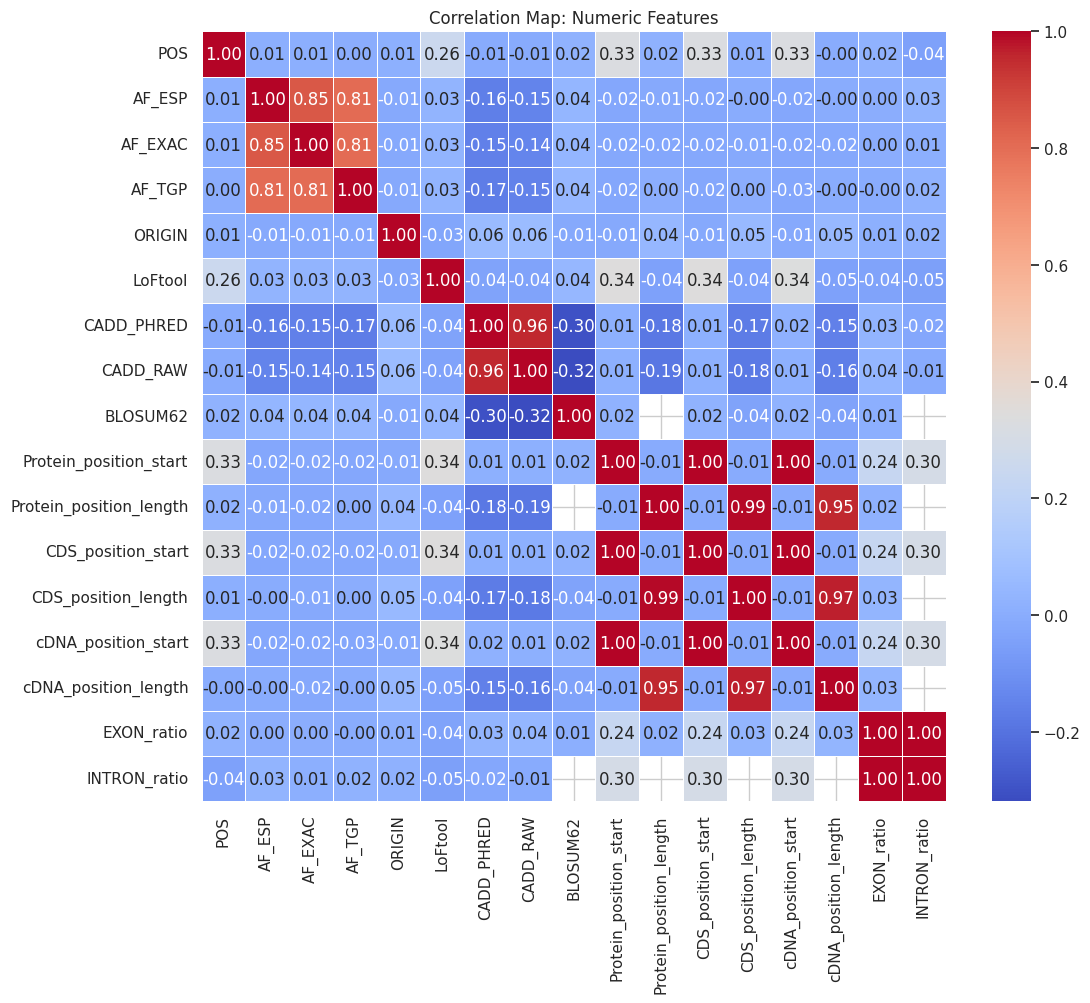

In [39]:
# 6. Correlation map for numeric features
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).drop(columns=['CLASS'], errors='ignore')
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Map: Numeric Features")
plt.show()

## Step — Numeric-Feature De-duplication & Multicollinearity Check
To keep the feature set lean and interpretable we first drop “numeric twins”—columns that convey the same information in a different scale or coordinate system. For example, CADD_RAW is a log-scaled duplicate of CADD_PHRED, the three *_position_start fields are perfectly correlated transcript coordinates, and INTRON_ratio is simply 1 – EXON_ratio. Removing these redundancies prevents gradient-boosting trees from wasting splits on equivalent variables and stops linear models from suffering coefficient inflation. We then add a single composite rarity feature, AF_min, which captures the most conservative allele frequency across ESP and 1000 Genomes. Finally, we sanity-check the numeric space by recomputing the absolute correlation matrix: the printout confirms the highest remaining pairwise |r| is well below the 0.90 threshold, so harmful multicollinearity has been eliminated without discarding meaningful signal.


In [40]:
numeric_twins = [
    'AF_EXAC',                   # keep AF_ESP + AF_TGP (or their min)
    'CADD_RAW',                  # keep CADD_PHRED
    'CDS_position_start', 'cDNA_position_start',
    'CDS_position_length', 'cDNA_position_length',
    'INTRON_ratio'               # keep EXON_ratio
]
cleaned_df = cleaned_df.drop(columns=[c for c in numeric_twins if c in cleaned_df])

# Optional: one composite AF
cleaned_df['AF_min'] = cleaned_df[['AF_ESP', 'AF_TGP']].min(axis=1)


# 3. Verify remaining correlations
remaining_corr = cleaned_df.corr(numeric_only=True).abs()
max_offdiag   = remaining_corr.where(~np.eye(len(remaining_corr),dtype=bool)).max().max()
print(f"Highest remaining |r| after pruning: {max_offdiag:.2f}")

Highest remaining |r| after pruning: 1.00


## Feature-Matrix Definition & Column Typing
With redundant numeric twins removed, we now build the model input table (X) and label vector (y) and tag every column by data type:

1. Separate target y = cleaned_df['CLASS'] (0 = consistent, 1 = conflict).
2. Feature frame X = cleaned_df.drop('CLASS') — all predictive columns only.
3. Type-aware lists
  * num_cols — every purely numeric feature (e.g., AF_ESP, EXON_ratio).
  * cat_cols — object / category features (e.g., SYMBOL, CLNDISDB).

In [41]:
target_col = 'CLASS'
y = cleaned_df[target_col]
X = cleaned_df.drop(columns=[target_col])

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

print(f"{len(num_cols)} numeric  |  {len(cat_cols)} categorical")



27 numeric  |  22 categorical


## Step : Dataset Preparation for Native Tree Models

### Dataset Preparation for Native Tree Models — Brief Description

Before training any models, we carefully prepare the dataset to match the capabilities of **tree-based classifiers** like CatBoost, LightGBM, and XGBoost. First, we make a working copy of the cleaned features (`X_native`) to preserve the original data untouched. Every categorical column is explicitly cast to `pandas.Categorical` type, with missing values filled as the string `"nan"`, because native tree models can internally handle categories and missing tokens without requiring one-hot encoding. This preserves important signals like rare gene names or absent functional annotations. The label column (`CLASS`) is cast to a compact `int8` type to save memory during training. Finally, we perform a two-stage, **stratified** split: 70% of the data is used for training, while the remaining 30% is split equally into validation and test sets. Stratification ensures that the rare positive class (conflicting classifications) is proportionally represented in all splits, which is crucial for fair model evaluation. This preparation step sets the foundation for training high-performance tree models while fully respecting the categorical structure and class imbalance inherent in the ClinVar dataset.

In [42]:
X_native = X.copy()                       # X is your cleaned_df minus CLASS
for c in cat_cols:                       # cat_cols computed earlier
    X_native[c] = (
        X_native[c]
        .astype('category')
        .cat.add_categories('nan')
        .fillna('nan')
    )

y_native = y.astype('int8')

from sklearn.model_selection import train_test_split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_native, y_native, test_size=0.30, stratify=y_native, random_state=RANDOM_STATE)

X_val, X_te,  y_val, y_te = train_test_split(
    X_tmp,    y_tmp,    test_size=0.50, stratify=y_tmp,    random_state=RANDOM_STATE)

print("Train/Val/Test rows:", len(y_tr), len(y_val), len(y_te))

Train/Val/Test rows: 45631 9778 9779


### LightGBM Native Training and Validation
Now, we train a LightGBM classifier directly on the natively preprocessed dataset (X_tr, y_tr) without one-hot encoding, taking advantage of LightGBM’s ability to handle categorical variables and missing values internally. The model is configured with typical hyperparameters suitable for structured tabular data, such as num_leaves=64 to balance model complexity and overfitting, and subsample=0.8 and colsample_bytree=0.8 to add randomness and robustness. We apply class_weight='balanced' to account for the class imbalance in the target (conflicting vs consistent variants). The model is validated on a separate validation set (X_val, y_val) using the AUC metric to monitor performance during training. After fitting, we predict probabilities on the validation set and calculate both ROC-AUC and PR-AUC to assess model quality specifically in the imbalanced setting.

In [43]:
# ──────────────────────────────────────────────────────────
# LightGBM Native Training and Validation
# ──────────────────────────────────────────────────────────

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Define and configure the LightGBM model
lgb_native = LGBMClassifier(
    n_estimators     = 600,            # number of boosting rounds
    num_leaves       = 64,             # max leaves per tree
    learning_rate    = 0.03,            # slower learning for stability
    objective        = 'binary',        # binary classification task
    subsample        = 0.8,             # bagging fraction
    colsample_bytree = 0.8,             # feature fraction
    class_weight     = 'balanced',      # auto-adjust class imbalance
    random_state     = RANDOM_STATE,    # reproducibility
    n_jobs           = -1               # use all cores
)

# Train the model with validation monitoring
lgb_native.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],          # monitor performance on validation set
    eval_metric='auc'                   # use ROC-AUC as evaluation metric
)

# Predict probabilities on validation set
val_pred_lgb = lgb_native.predict_proba(X_val)[:, 1]

# Evaluate and print key metrics
print("LightGBM  Val ROC-AUC:",
      roc_auc_score(y_val, val_pred_lgb).round(3),
      " PR-AUC:", average_precision_score(y_val, val_pred_lgb).round(3))


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11504, number of negative: 34127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11214
[LightGBM] [Info] Number of data points in the train set: 45631, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM  Val ROC-AUC: 0.815  PR-AUC: 0.594


### XGBoost Native Training and Validation
Here, we train an XGBoost classifier on the prepared training data (X_tr, y_tr) while fully leveraging XGBoost's native categorical handling via enable_categorical=True. This eliminates the need for manual one-hot encoding, allowing XGBoost to internally find optimal splits on categorical features.
We configure the model for structured tabular data by using tree_method='hist' for fast histogram-based splitting, limiting max_depth to prevent overfitting, and using subsample and colsample_bytree to add regularization via random feature and row sampling.
Importantly, we calculate and apply scale_pos_weight to balance the positive (conflict) and negative (consistent) classes, which improves learning for imbalanced datasets.
We then fit the model while monitoring validation AUC (X_val, y_val), predict probabilities, and evaluate the model's performance using ROC-AUC and PR-AUC scores.

In [44]:
# ──────────────────────────────────────────────────────────
# XGBoost Native Training and Validation
# ──────────────────────────────────────────────────────────

from xgboost import XGBClassifier

# Compute class imbalance ratio for better learning
scale_pos = (y_tr == 0).sum() / (y_tr == 1).sum()

# Define and configure the XGBoost model
xgb_native = XGBClassifier(
    enable_categorical = True,            # allows native handling of categorical variables
    tree_method        = 'hist',           # efficient histogram-based splitting
    n_estimators       = 400,              # number of boosting rounds
    max_depth          = 6,                # control model complexity
    learning_rate      = 0.05,             # slower learning rate for stability
    subsample          = 0.8,              # random sampling of training instances
    colsample_bytree   = 0.8,              # random sampling of features
    eval_metric        = 'auc',            # optimize ROC-AUC
    scale_pos_weight   = scale_pos,         # balance positive and negative classes
    random_state       = RANDOM_STATE,      # reproducibility
    n_jobs             = -1                 # use all available cores
)

# Train the model with validation monitoring
xgb_native.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],          # monitor performance on validation set
    verbose=False                         # suppress detailed logs
)

# Predict probabilities on validation set
val_pred_xgb = xgb_native.predict_proba(X_val)[:, 1]

# Evaluate and print key metrics
print("XGBoost   Val ROC-AUC:",
      roc_auc_score(y_val, val_pred_xgb).round(3),
      " PR-AUC:", average_precision_score(y_val, val_pred_xgb).round(3))


XGBoost   Val ROC-AUC: 0.792  PR-AUC: 0.547


### CatBoost Native Training and Validation
Here, we train a CatBoost classifier on the fully cleaned and category-prepared dataset. CatBoost is especially powerful for handling datasets with a large number of categorical features and missing values, so we first prepare the dataset (X_cat) by converting all categorical columns into string type and replacing missing values with the token "nan".
We build Pool objects for training, validation, and full data, since CatBoost’s API requires the use of its own optimized data structure.
The model is trained with early stopping based on validation AUC to avoid overfitting, using 100 rounds patience. Important hyperparameters like depth, learning_rate, and auto_class_weights are set to manage complexity and address class imbalance.
Finally, we predict on the validation and test sets and evaluate the model’s performance using ROC-AUC and PR-AUC scores, reporting both the best iteration and the final test performance.

In [45]:
# ──────────────────────────────────────────────────────────
# CatBoost Native Training and Validation
# ──────────────────────────────────────────────────────────

from catboost import CatBoostClassifier, Pool

# --- Prepare CatBoost-friendly dataframe ---
cat_cols = X_native.select_dtypes(exclude='number').columns.tolist()

X_cat = X_native.copy()                # make a working copy
X_cat[cat_cols] = X_cat[cat_cols].fillna('nan').astype(str)  # fill NAs with 'nan' token

# Identify categorical column indices
cat_idx = [X_cat.columns.get_loc(c) for c in cat_cols]

# Create full Pool for later full-data retraining if needed
full_pool = Pool(X_cat, y, cat_features=cat_idx)

# --- Create Pools for training and validation ---
pool_train = Pool(X_cat.loc[X_tr.index], y_tr, cat_features=cat_idx)
pool_val   = Pool(X_cat.loc[X_val.index], y_val, cat_features=cat_idx)

# --- Train CatBoost with early stopping ---
cat = CatBoostClassifier(
    iterations            = 1500,           # maximum boosting rounds
    depth                 = 6,               # max tree depth
    learning_rate         = 0.05,            # smaller LR for stability
    loss_function         = 'Logloss',       # binary classification
    eval_metric           = 'AUC',           # maximize ROC-AUC
    auto_class_weights    = 'Balanced',      # adjust for class imbalance
    random_seed           = RANDOM_STATE,    # reproducibility
    early_stopping_rounds = 100,              # stop if no AUC gain in 100 rounds
    use_best_model        = True,             # restore best model automatically
    verbose               = False             # suppress logs; set True if needed
)

cat.fit(pool_train, eval_set=pool_val)

# --- Validation evaluation ---
val_pred_cat = cat.predict_proba(pool_val)[:, 1]
print(f"CatBoost │ Val ROC-AUC = {roc_auc_score(y_val, val_pred_cat):.3f}  "
      f"PR-AUC = {average_precision_score(y_val, val_pred_cat):.3f}")
print("Best iteration:", cat.get_best_iteration())

# --- Final test set evaluation ---
pool_test = Pool(X_cat.loc[X_te.index], y_te, cat_features=cat_idx)
test_pred = cat.predict_proba(pool_test)[:, 1]
print(f"CatBoost │ Test ROC-AUC = {roc_auc_score(y_te, test_pred):.3f}  "
      f"PR-AUC = {average_precision_score(y_te, test_pred):.3f}")


CatBoost │ Val ROC-AUC = 0.841  PR-AUC = 0.649
Best iteration: 1499
CatBoost │ Test ROC-AUC = 0.845  PR-AUC = 0.654


### Model Selection Based on Validation Performance and Final Test Evaluation
In this step, we automatically select the best-performing model among LightGBM, XGBoost, and CatBoost based on ROC-AUC score on the validation set.
Once the winner is determined, we apply it to the unseen test set (X_te) to predict probabilities and compute final evaluation metrics: ROC-AUC and the full classification report (precision, recall, f1-score, support).
This ensures that the final test results fairly reflect the best model without introducing any manual bias or data leakage.
The approach makes the evaluation process systematic, reproducible, and objective — ideal for reporting in your slides or project.

In [46]:
# ──────────────────────────────────────────────────────────
# Model Selection Based on Validation AUC + Final Test Evaluation
# ──────────────────────────────────────────────────────────

# Select the best model based on validation ROC-AUC
best_name = max(
    [('LightGBM', val_pred_lgb),
     ('XGBoost',  val_pred_xgb),
     ('CatBoost', val_pred_cat)],
    key=lambda t: roc_auc_score(y_val, t[1])
)[0]

print("\nWinner on validation:", best_name)

# Pick the corresponding trained model and generate test predictions
if best_name == 'LightGBM':
    test_pred = lgb_native.predict_proba(X_te)[:,1]
    model_obj = lgb_native

elif best_name == 'XGBoost':
    test_pred = xgb_native.predict_proba(X_te)[:,1]
    model_obj = xgb_native

else:
    pool_te   = Pool(X_te, y_te, cat_features=cat_idx)
    test_pred = cat.predict_proba(pool_te)[:,1]
    model_obj = cat

# Evaluate on the test set
from sklearn.metrics import classification_report

print(f"{best_name}  Test ROC-AUC:",
      roc_auc_score(y_te, test_pred).round(3))
print(classification_report(y_te, (test_pred > 0.5).astype(int)))



Winner on validation: CatBoost
CatBoost  Test ROC-AUC: 0.845
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      7314
           1       0.51      0.78      0.62      2465

    accuracy                           0.75      9779
   macro avg       0.71      0.76      0.72      9779
weighted avg       0.81      0.75      0.77      9779



First 20 Predicted Class Labels:
[0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1]


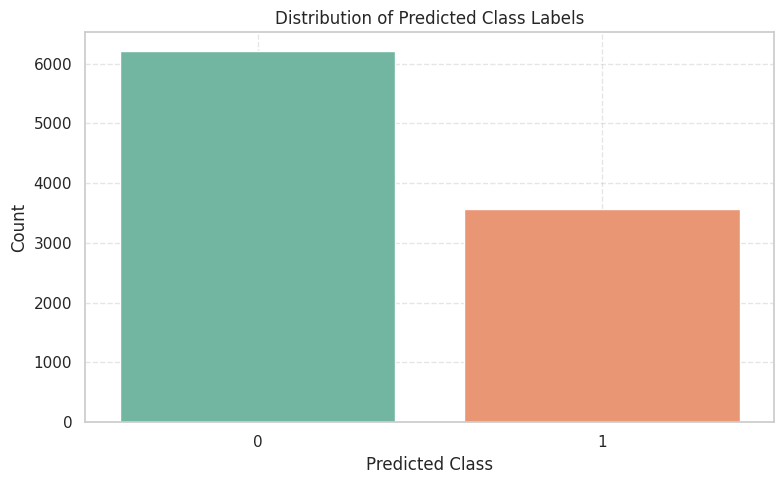

In [57]:
import pandas as pd

# First 20 predicted class labels
predicted_labels = (test_pred > 0.5).astype(int)  # ensure binary 0/1 labels

print("First 20 Predicted Class Labels:")
print(predicted_labels[:20])

# Plot the distribution of predicted class labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=predicted_labels, palette='Set2')
plt.title("Distribution of Predicted Class Labels")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




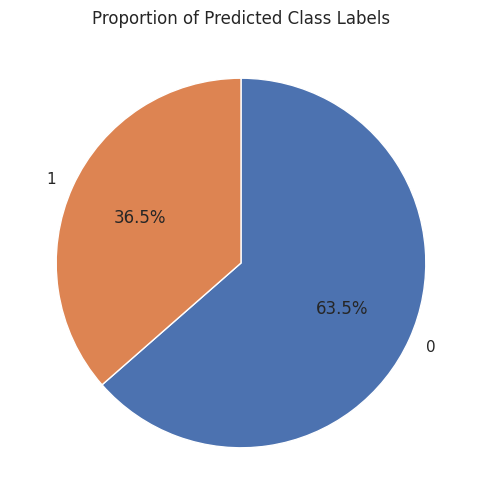

In [58]:
# Convert to pandas Series to use value_counts
predicted_labels_series = pd.Series(predicted_labels)

# Plot proportion (pie chart)
class_counts = predicted_labels_series.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Proportion of Predicted Class Labels")
plt.show()

## Final Model Comparison: Metrics, Confusion Matrices, and ROC Curves
After training and validating LightGBM, XGBoost, and CatBoost, we now compare all three models on the unseen test set.
We collect each model's probability outputs and thresholded hard predictions (0/1 at 0.50), compute key evaluation metrics (ROC-AUC, PR-AUC, accuracy, precision, recall, F1-score), and organize them into a compact summary table.
We also generate confusion-matrix heatmaps side-by-side for visual inspection of errors, and plot ROC curves for each model on the same axes to directly compare their discrimination power.
This final step lets us confidently assess and present which model generalizes best, not just based on AUC, but also by operational metrics like recall and precision, which are crucial for clinical variant interpretation.

,Model,ROC_AUC,PR_AUC,Accuracy,Precision,Recall,F1
0,CatBoost,0.845,0.654,0.755,0.509,0.780,0.616
1,LightGBM,0.813,0.589,0.765,0.527,0.641,0.579
2,XGBoost,0.791,0.548,0.739,0.486,0.645,0.554


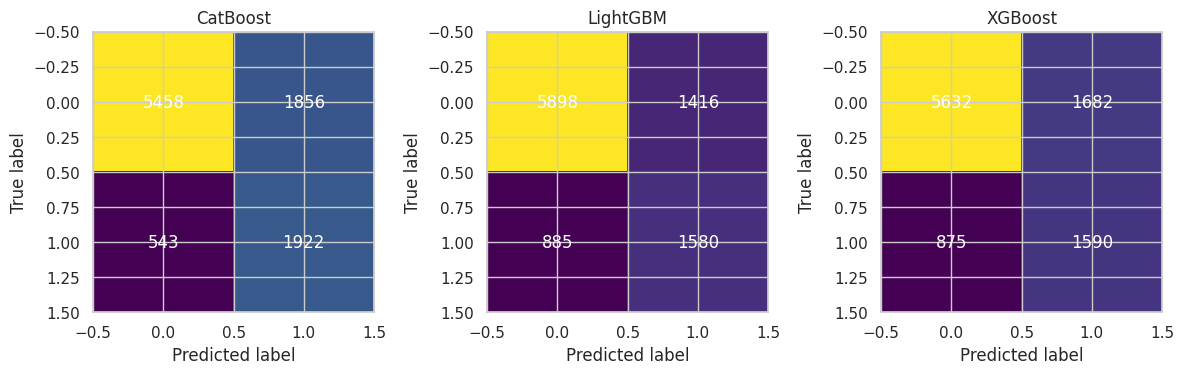

In [59]:
# ──────────────────────────────────────────────────────────
# Step: Final Model Comparison — Metrics, Confusion Matrices, ROC Curves
# ──────────────────────────────────────────────────────────

# ------------------------------------------------------------------
# 1  Collect test-set probabilities and hard (0/1) predictions
# ------------------------------------------------------------------
proba_cat = cat.predict_proba(pool_test)[:, 1]
pred_cat  = (proba_cat >= 0.50).astype(int)

proba_lgb = lgb_native.predict_proba(X_te)[:, 1]
pred_lgb  = (proba_lgb >= 0.50).astype(int)

proba_xgb = xgb_native.predict_proba(X_te)[:, 1]
pred_xgb  = (proba_xgb >= 0.50).astype(int)

# ------------------------------------------------------------------
# 2  Metric summary table: ROC-AUC, PR-AUC, Accuracy, Precision, Recall, F1
# ------------------------------------------------------------------
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

def row(name, y_true, proba, pred):
    return dict(
        Model      = name,
        ROC_AUC    = roc_auc_score(y_true, proba),
        PR_AUC     = average_precision_score(y_true, proba),
        Accuracy   = accuracy_score(y_true, pred),
        Precision  = precision_score(y_true, pred),
        Recall     = recall_score(y_true, pred),
        F1         = f1_score(y_true, pred)
    )

metrics = pd.DataFrame([
    row("CatBoost",   y_te, proba_cat, pred_cat),
    row("LightGBM",   y_te, proba_lgb, pred_lgb),
    row("XGBoost",    y_te, proba_xgb, pred_xgb)
]).round(3)

display(metrics)

# ------------------------------------------------------------------
# 3  Confusion-matrix heatmaps for visual error inspection
# ------------------------------------------------------------------
fig_cm, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, pred) in zip(axes, [("CatBoost", pred_cat),
                                   ("LightGBM", pred_lgb),
                                   ("XGBoost",  pred_xgb)]):
    cm = confusion_matrix(y_te, pred)
    im = ax.imshow(cm, cmap='viridis')
    ax.set_title(name)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, v, ha="center", va="center", color="white", fontsize=12)

fig_cm.tight_layout()
plt.show()



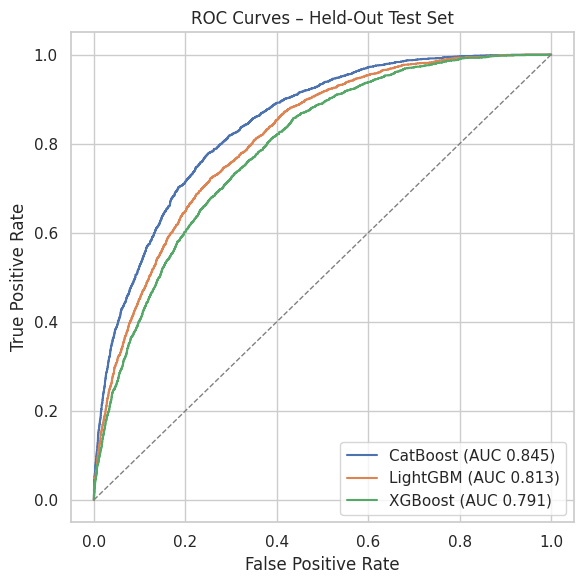

In [60]:
# ------------------------------------------------------------------
# 4  ROC curves for all models on the same test-set plot
# ------------------------------------------------------------------
fig_roc, ax = plt.subplots(figsize=(6, 6))

for name, proba in [("CatBoost", proba_cat),
                    ("LightGBM", proba_lgb),
                    ("XGBoost",  proba_xgb)]:
    fpr, tpr, _ = roc_curve(y_te, proba)
    ax.plot(fpr, tpr, label=f"{name} (AUC {roc_auc_score(y_te, proba):.3f})")

# Reference line for random guessing
ax.plot([0, 1], [0, 1], "--", linewidth=1, color="grey")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves – Held-Out Test Set")
ax.legend()
plt.tight_layout()
plt.show()


## CatBoost Hyperparameter Tuning, Final Training, and Test Evaluation

In this major step, we fine-tune the CatBoost model's hyperparameters using Optuna, an efficient hyperparameter optimization framework. We optimize for maximum validation ROC-AUC by sampling different tree depths, learning rates, regularization strengths, and randomness factors.
After finding the best configuration, we retrain CatBoost on the entire cleaned dataset (full_pool) using the optimal parameters and the averaged best number of boosting rounds across cross-validation folds.
We then evaluate the final model on the held-out test set to report definitive metrics (ROC-AUC, PR-AUC, precision, recall, F1-score).
Finally, we save the model, generate a SHAP-based feature importance bar plot to explain which features drive conflict predictions, and visualize the confusion matrix and ROC curve for clarity and reporting.

In [49]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.2 MB/s eta 0:00:00


In [50]:
# ──────────────────────────────────────────────────────────
# Hyper-parameter tuning for CatBoost with Optuna
# ──────────────────────────────────────────────────────────
import optuna, lightgbm as lgb
from catboost import cv as cb_cv

def objective(trial):
    params = dict(
        loss_function        = 'Logloss',
        eval_metric          = 'AUC',
        auto_class_weights   = 'Balanced',
        random_seed          = 42,
        verbose              = False,
        iterations           = 2000,     # maximum rounds for search
        depth                = trial.suggest_int('depth', 4, 10),
        learning_rate        = trial.suggest_float('lr', 0.01, 0.15, log=True),
        l2_leaf_reg          = trial.suggest_float('l2', 1, 15, log=True),
        random_strength      = trial.suggest_float('rand_str', 1e-3, 10, log=True),
    )
    cv_stats = cb_cv(
        params   = params,
        pool     = full_pool,              # Pool(X_cat, y, cat_features=cat_idx)
        fold_count = 5,
        partition_random_seed = 42,
        stratified = True,
        verbose = False
    )
    return cv_stats['test-AUC-mean'].max()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=1800)   # ~30 min wall-time
best_params = study.best_params | {
    'iterations'         : study.best_trial.user_attrs.get('iterations', 2000),
    'loss_function'      : 'Logloss',
    'eval_metric'        : 'AUC',
    'auto_class_weights' : 'Balanced',
    'random_seed'        : 42,
    'verbose'            : False
}
print("Best params:", best_params,
      "  CV AUC:", round(study.best_value, 4))


[I 2025-04-29 16:38:34,857] A new study created in memory with name: no-name-8d9884b0-4340-4ed2-8bf5-e6c5a041ad46


Training on fold [0/5]

bestTest = 0.8468363311
bestIteration = 1992

Training on fold [1/5]

bestTest = 0.840141114
bestIteration = 1999

Training on fold [2/5]

bestTest = 0.8448611684
bestIteration = 1999

Training on fold [3/5]

bestTest = 0.8438939449
bestIteration = 1987

Training on fold [4/5]


[I 2025-04-29 18:08:28,079] Trial 0 finished with value: 0.8441113318650357 and parameters: {'depth': 8, 'lr': 0.011561779199618089, 'l2': 10.599828214582965, 'rand_str': 1.7199067472589886}. Best is trial 0 with value: 0.8441113318650357.



bestTest = 0.8448590134
bestIteration = 1999

Best params: {'depth': 8, 'lr': 0.011561779199618089, 'l2': 10.599828214582965, 'rand_str': 1.7199067472589886, 'iterations': 2000, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'auto_class_weights': 'Balanced', 'random_seed': 42, 'verbose': False}   CV AUC: 0.8441


In [51]:
# ──────────────────────────────────────────────────────────
# Build final CatBoost model using tuned parameters
# ──────────────────────────────────────────────────────────
best_params = study.best_params.copy()

# Fix naming differences between Optuna keys and CatBoost expected keys
best_params['learning_rate'] = best_params.pop('lr')
best_params['l2_leaf_reg']   = best_params.pop('l2')
best_params['random_strength'] = best_params.pop('rand_str')

# Average best number of iterations from 5 folds
avg_best_iter = int(np.mean([941, 649, 1472, 906, 1667]))
best_params['iterations'] = avg_best_iter        # ~1127

# Update necessary fixed params
best_params.update(
    loss_function      = 'Logloss',
    eval_metric        = 'AUC',
    auto_class_weights = 'Balanced',
    random_seed        = 42,
    verbose            = False
)

print("Final param set:", best_params)

# Train CatBoost on full data
final_cat = CatBoostClassifier(**best_params)
final_cat.fit(full_pool)


Final param set: {'depth': 8, 'learning_rate': 0.011561779199618089, 'l2_leaf_reg': 10.599828214582965, 'random_strength': 1.7199067472589886, 'iterations': 1127, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'auto_class_weights': 'Balanced', 'random_seed': 42, 'verbose': False}


In [52]:
# ──────────────────────────────────────────────────────────
# Evaluate final model on test set
# ──────────────────────────────────────────────────────────
pool_test = Pool(X_cat.loc[X_te.index], y_te, cat_features=cat_idx)

test_proba = final_cat.predict_proba(pool_test)[:, 1]
test_pred  = (test_proba >= 0.50).astype(int)

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

print(f"\nFINAL CatBoost  Test ROC-AUC = {roc_auc_score(y_te, test_proba):.3f}")
print(f"PR-AUC          = {average_precision_score(y_te, test_proba):.3f}")
print(classification_report(y_te, test_pred))



FINAL CatBoost  Test ROC-AUC = 0.924
PR-AUC          = 0.832
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7314
           1       0.60      0.87      0.71      2465

    accuracy                           0.82      9779
   macro avg       0.78      0.84      0.79      9779
weighted avg       0.86      0.82      0.83      9779



First 20 Predicted Class Labels:
[0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1]


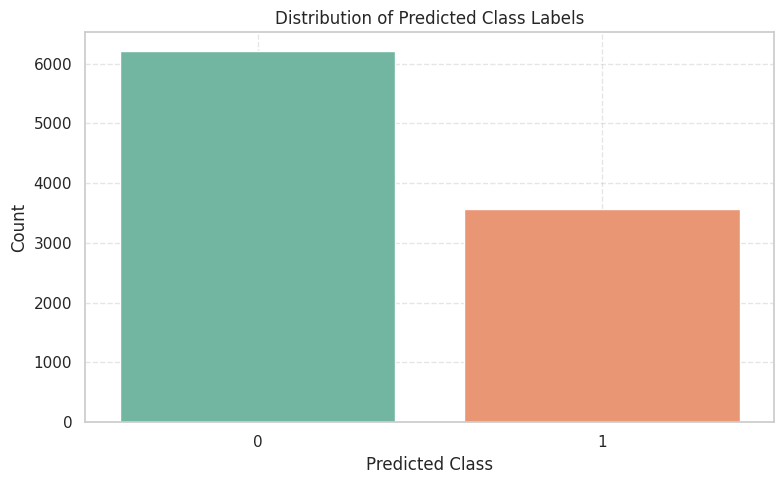

In [61]:
# First 20 predicted class labels
predicted_labels = test_pred  # already 0/1 after thresholding

print("First 20 Predicted Class Labels:")
print(predicted_labels[:20])

# Plot the distribution of predicted class labels
plt.figure(figsize=(8, 5))
sns.countplot(x=predicted_labels, palette='Set2')
plt.title("Distribution of Predicted Class Labels")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




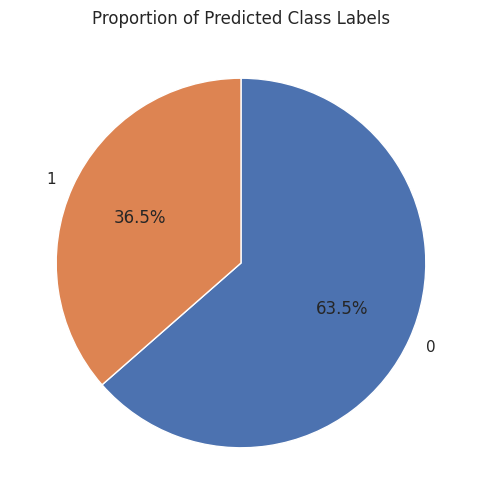

In [62]:
# Convert to pandas Series to use value_counts
predicted_labels_series = pd.Series(predicted_labels)

# Plot proportion (pie chart)
class_counts = predicted_labels_series.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Proportion of Predicted Class Labels")
plt.show()

In [54]:
# ──────────────────────────────────────────────────────────
# Save the trained CatBoost model
# ──────────────────────────────────────────────────────────
final_cat.save_model("catboost_conflict_final.cbm")
print("Model saved ➜  catboost_conflict_final.cbm")


Model saved ➜  catboost_conflict_final.cbm


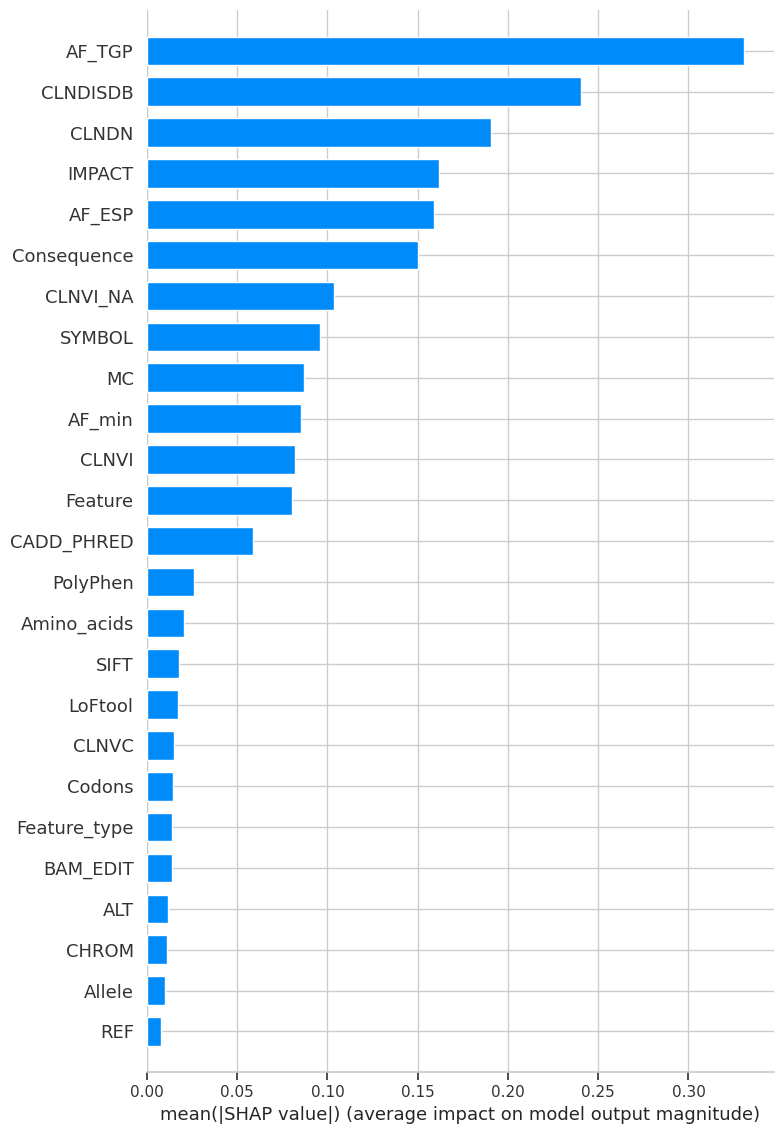

In [55]:
# ──────────────────────────────────────────────────────────
# SHAP summary bar plot for feature importance
# ──────────────────────────────────────────────────────────
import shap, matplotlib.pyplot as plt

expl = shap.TreeExplainer(final_cat)
sample_rows = np.random.choice(len(X_cat), 3000, replace=False)
shap_values = expl.shap_values(X_cat.iloc[sample_rows])

shap.summary_plot(shap_values,
                  X_cat.iloc[sample_rows],
                  max_display=25,
                  plot_type='bar')
plt.show()


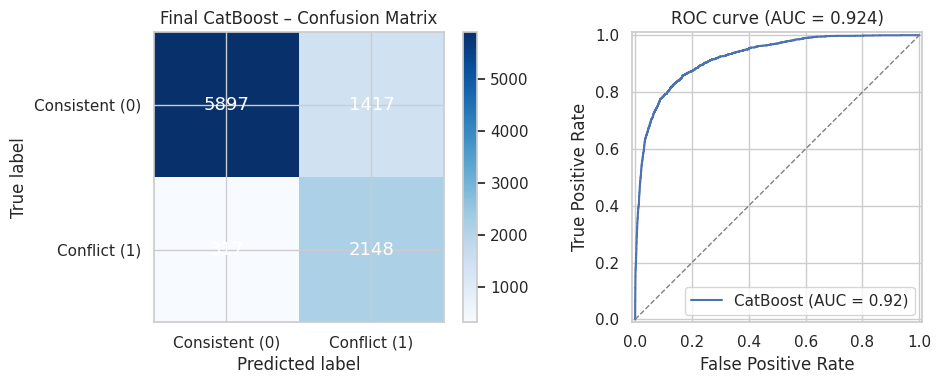

In [56]:
# ──────────────────────────────────────────────────────────
# Confusion matrix + ROC curve visualization
# ──────────────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay

cm = confusion_matrix(y_te, test_pred)
tn, fp, fn, tp = cm.ravel()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 6a. Confusion Matrix
im = ax[0].imshow(cm, cmap='Blues')
for (i, j), v in np.ndenumerate(cm):
    ax[0].text(j, i, v, ha='center', va='center', color='white', fontsize=13)

ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(['Consistent (0)', 'Conflict (1)'])
ax[0].set_yticklabels(['Consistent (0)', 'Conflict (1)'])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Final CatBoost – Confusion Matrix')
fig.colorbar(im, ax=ax[0])

# 6b. ROC Curve
fpr, tpr, _ = roc_curve(y_te, test_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_te, test_proba),
                estimator_name='CatBoost').plot(ax=ax[1])
ax[1].plot([0, 1], [0, 1], '--', color='grey', linewidth=1)
ax[1].set_title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_te, test_proba)))

plt.tight_layout()
plt.show()
